# Automatic Ticket Classification

## Problem Statement

For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers. 

These customer complaints are unstructured text data; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.

With the help of non-negative matrix factorization (NMF), an approach under topic modelling, you will detect patterns and recurring words present in each ticket. This can be then used to understand the important features for each cluster of categories. By segregating the clusters, you will be able to identify the topics of the customer complaints. 

You will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

> Credit card / Prepaid card

> Bank account services

> Theft/Dispute reporting

> Mortgages/loans

> Others 

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, string
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem.wordnet import WordNetLemmatizer

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from pprint import pprint

In [2]:
## Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting max rows and columns
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

In [4]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Debarshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Debarshi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Debarshi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:

# Installing wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Import pickle to save and load the model
import pickle

### Load data

In [6]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json') 
  
# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)


### Prepare Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 
              'issue', 'date_received','state', 'consumer_disputed', 'product',
              'company_response', 'company', 'submitted_via','date_sent_to_company', 
              'company_public_response','sub_product', 'timely',
              'complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [10]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#Assign nan in place of blanks in the complaints column
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [12]:
df[df.loc[:, 'complaint_what_happened'] == '']

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided


In [13]:
# check the dimension
df.shape

(78313, 22)

In [14]:
#Remove all rows where complaints column is nan and recheck the dimension
df = df[~df['complaint_what_happened'].isnull()]
df.shape

(21072, 22)

### Prepare for text modelling

In [15]:
# We will write a function to perform the following tasks
# Make the text lowercase
# Remove text in square brackets
# Remove punctuation
# Remove words containing numbers
def clean_text(sentence):
    sentence = sentence.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sentence = re.sub(pattern, '', sentence) 
    pattern = '\w*\d\w*' # Removing words with numbers in between
    sentence = re.sub(pattern, '', sentence) 
    return sentence

In [16]:
# Perform the action of cleaning
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str) # Convert complaint_what_happened column to string
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [17]:
df_clean

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [18]:
#Write your function to Lemmatize the text
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)

In [19]:
#Adding a column to df_clean' that will have  the lemmatized complaints 
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmatize_words)

In [20]:
df_clean

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...


In [21]:
df_clean['tokenized'] = df_clean['complaint_lemmatized'].str.lower().apply(nltk.word_tokenize)

In [22]:
df_clean['tagged'] = df_clean['tokenized'].apply(nltk.pos_tag)

In [23]:
df_clean['complaint_POS_removed'] = df_clean['tagged'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])

In [24]:
df_clean

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","[morning, name, xxxx, stop, bank, cardmember, ..."
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","[i, card, agent, upgrade, date, agent, informa..."
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","[card, report, application, identity, consent,..."
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","[try, book, xxxx, ticket, i, offer, ticket, ca..."
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","[son, deposit, chase, account, fund, bank, acc..."
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,"[after, be, a, chase, card, customer, for, wel...","[(after, IN), (be, VB), (a, DT), (chase, JJ), ...","[card, customer, decade, solicitations, credit..."
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,"[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[(on, IN), (wednesday, JJ), (xxxxxxxx, NNP), (...","[xxxxxxxx, i, call, chas, xxxx, visa, credit, ..."
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[(i, RB), (be, VB), (not, RB), (familiar, JJ),...","[pay, risk, provide, consumers, bank, app, i, ..."
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...,"[i, have, have, flawless, credit, for, yrs, iv...","[(i, NNS), (have, VBP), (have, VBP), (flawless...","[i, credit, credit, card, chase, freedom, xxxx..."


### EDA

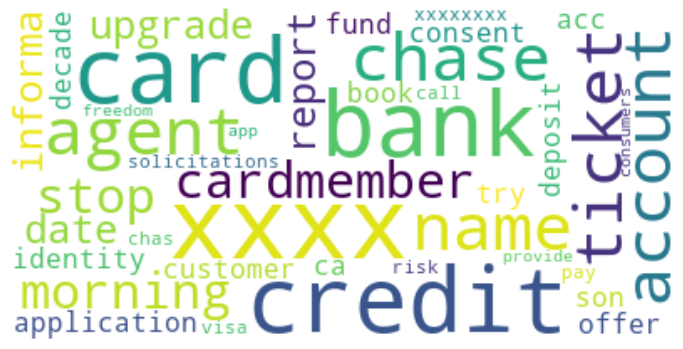

In [25]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
df_clean

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","[morning, name, xxxx, stop, bank, cardmember, ..."
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","[i, card, agent, upgrade, date, agent, informa..."
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","[card, report, application, identity, consent,..."
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","[try, book, xxxx, ticket, i, offer, ticket, ca..."
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","[son, deposit, chase, account, fund, bank, acc..."
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,"[after, be, a, chase, card, customer, for, wel...","[(after, IN), (be, VB), (a, DT), (chase, JJ), ...","[card, customer, decade, solicitations, credit..."
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,"[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[(on, IN), (wednesday, JJ), (xxxxxxxx, NNP), (...","[xxxxxxxx, i, call, chas, xxxx, visa, credit, ..."
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[(i, RB), (be, VB), (not, RB), (familiar, JJ),...","[pay, risk, provide, consumers, bank, app, i, ..."
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...,"[i, have, have, flawless, credit, for, yrs, iv...","[(i, NNS), (have, VBP), (have, VBP), (flawless...","[i, credit, credit, card, chase, freedom, xxxx..."


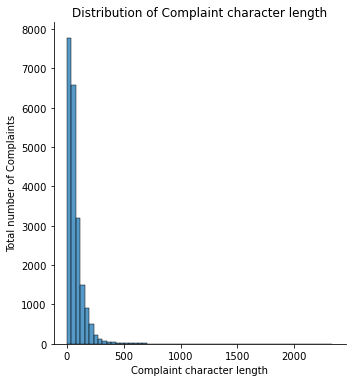

In [32]:
#  visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

In [33]:
# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [34]:
top_30words = get_top_ngrams(df_clean['complaint_POS_removed'].astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,xxxx,149848
1,chase,49489
2,account,47523
3,credit,34175
4,bank,30058
...,...,...
25,days,7468
26,payments,7205
27,fund,7118
28,fraud,7061


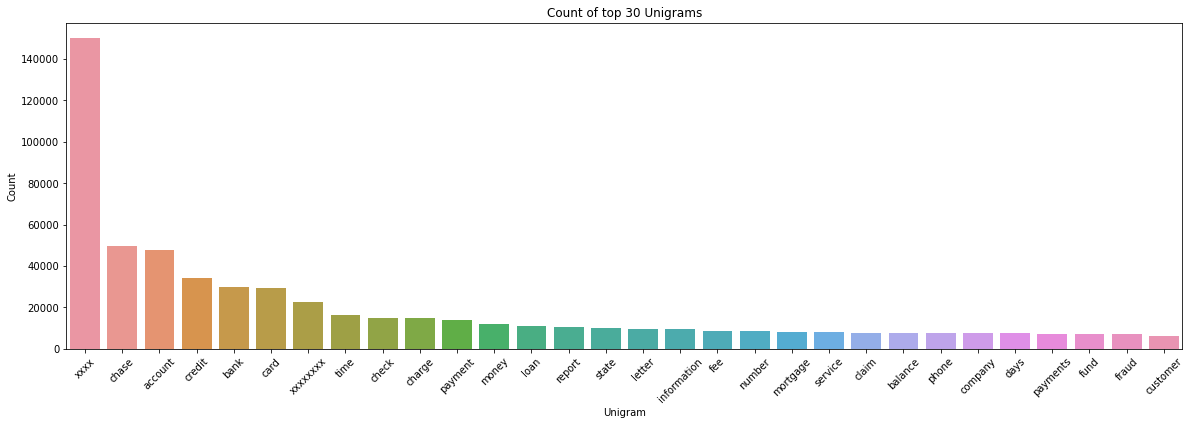

In [35]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [36]:
# find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['complaint_POS_removed'].astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,xxxx xxxx,68942
1,credit card,12784
2,credit report,4958
3,check account,4363
4,xxxx chase,3315
...,...,...
25,card account,1531
26,number xxxx,1515
27,account credit,1373
28,card chase,1297


In [37]:
# find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['complaint_POS_removed'].astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,xxxx xxxx xxxx,35171
1,chase credit card,1992
2,xxxxxxxx xxxx xxxx,1580
3,xxxx xxxx chase,1340
4,xxxx xxxx xxxxxxxx,1300
...,...,...
25,charge xxxx xxxx,403
26,xxxx xxxx state,398
27,charge credit card,394
28,xxxx xxxx check,391


In [38]:
# The personal details of customer has been masked in the dataset with xxxx. 
# Let's remove the masked text as this will be of no use for our analysis
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].astype(str)
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')
df_clean

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm..."
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","['i', 'card', 'agent', 'upgrade', 'date', 'age...","['i', 'card', 'agent', 'upgrade', 'date', 'age..."
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","['card', 'report', 'application', 'identity', ...","['card', 'report', 'application', 'identity', ..."
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","['try', 'book', 'xxxx', 'ticket', 'i', 'offer'...","['try', 'book', '', 'ticket', 'i', 'offer', 't..."
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',..."
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,"[after, be, a, chase, card, customer, for, wel...","[(after, IN), (be, VB), (a, DT), (chase, JJ), ...","['card', 'customer', 'decade', 'solicitations'...","['card', 'customer', 'decade', 'solicitations'..."
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,"[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[(on, IN), (wednesday, JJ), (xxxxxxxx, NNP), (...","['xxxxxxxx', 'i', 'call', 'chas', 'xxxx', 'vis...","['', 'i', 'call', 'chas', '', 'visa', 'credit'..."
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[(i, RB), (be, VB), (not, RB), (familiar, JJ),...","['pay', 'risk', 'provide', 'consumers', 'bank'...","['pay', 'risk', 'provide', 'consumers', 'bank'..."
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...,"[i, have, have, flawless, credit, for, yrs, iv...","[(i, NNS), (have, VBP), (have, VBP), (flawless...","['i', 'credit', 'credit', 'card', 'chase', 'fr...","['i', 'credit', 'credit', 'card', 'chase', 'fr..."


### Feature Extraction

- Convert the raw texts to a matrix of TF-IDF features

 - *max_df* is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

 - *min_df* is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
dtm

<21072x7978 sparse matrix of type '<class 'numpy.float64'>'
	with 671351 stored elements in Compressed Sparse Row format>

### Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

**In this task you have to perform the following:**

- Find the best number of clusters
- Apply the best number to create word clusters
- Inspect & validate the correction of each cluster wrt the complaints
- Correct the labels if needed
- Map the clusters to topics/cluster names

### Manual Topic Modeling
We will take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [40]:
from sklearn.decomposition import NMF

In [41]:
#Load  nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [42]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7978

In [43]:
H = nmf_model.components_       # Topic-term matrix

In [44]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,number,business,days,claim,transfer,cash,access
Topic 2,credit,card,report,account,chase,inquiry,score,inquiries,company,limit,information,debt,letter,balance,application
Topic 3,loan,mortgage,home,chase,modification,property,payments,time,letter,document,house,bank,years,foreclosure,rate
Topic 4,charge,card,chase,dispute,fee,fraud,purchase,claim,merchant,transaction,service,transactions,time,refund,phone
Topic 5,payment,payments,balance,fee,month,statement,pay,time,date,auto,account,days,chase,months,day


### Observation Looking at the topics above, for each topic, we can give a label based on their products/services:

**Topic 1** = Bank account services
**Topic 2** = Credit card / Prepaid card
**Topic 3** = Mortgages/loans
**Topic 4** = Theft/Dispute reporting
**Topic 5** = Others

In [45]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [46]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [47]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm...",0
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","['i', 'card', 'agent', 'upgrade', 'date', 'age...","['i', 'card', 'agent', 'upgrade', 'date', 'age...",1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","['card', 'report', 'application', 'identity', ...","['card', 'report', 'application', 'identity', ...",1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","['try', 'book', 'xxxx', 'ticket', 'i', 'offer'...","['try', 'book', '', 'ticket', 'i', 'offer', 't...",1
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',...",0


In [48]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm...",0
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',...",0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,"[with, out, notice, jp, morgan, chase, restric...","[(with, IN), (out, RP), (notice, JJ), (jp, NN)...","['jp', 'chase', 'account', 'debit', 'card', 't...","['jp', 'chase', 'account', 'debit', 'card', 't...",0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,"[mishandle, of, this, account, by, chase, auto...","[(mishandle, NN), (of, IN), (this, DT), (accou...","['mishandle', 'account', 'auto', 'xxxx']","['mishandle', 'account', 'auto', '']",0
27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,"[i, open, an, account, with, chase, bank, on, ...","[(i, NN), (open, VBP), (an, DT), (account, NN)...","['i', 'account', 'bank', 'xxxx', 'code', 'bonu...","['i', 'account', 'bank', '', 'code', 'bonus', ...",0
...,...,...,...,...,...,...,...
58,i made a purchase of on xxxxxxxx i made payme...,i make a purchase of on xxxxxxxx i make paymen...,"[i, make, a, purchase, of, on, xxxxxxxx, i, ma...","[(i, NNS), (make, VBP), (a, DT), (purchase, NN...","['i', 'purchase', 'xxxxxxxx', 'i', 'payments',...","['i', 'purchase', '', 'i', 'payments', '', '',...",4
141,action taken by the company between the dates ...,action take by the company between the date of...,"[action, take, by, the, company, between, the,...","[(action, NN), (take, VB), (by, IN), (the, DT)...","['action', 'company', 'date', 'xxxxxxxx', 'xxx...","['action', 'company', 'date', '', '', 'individ...",4
82,i recently called to ask chase bank why they r...,i recently call to ask chase bank why they rep...,"[i, recently, call, to, ask, chase, bank, why,...","[(i, NN), (recently, RB), (call, VBD), (to, TO...","['i', 'bank', 'credit', 'bureau', 'days', 'pay...","['i', 'bank', 'credit', 'bureau', 'days', 'pay...",4
20,during the summer months i experience a declin...,during the summer months i experience a declin...,"[during, the, summer, months, i, experience, a...","[(during, IN), (the, DT), (summer, NN), (month...","['summer', 'months', 'income', 'employment', '...","['summer', 'months', 'income', 'employment', '...",4


In [51]:
df_clean_5.loc[df_clean_5['Topic'] == 0] ## inspecting rows for Topic 1 - Bank Account services

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm...",0
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',...",0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,"[with, out, notice, jp, morgan, chase, restric...","[(with, IN), (out, RP), (notice, JJ), (jp, NN)...","['jp', 'chase', 'account', 'debit', 'card', 't...","['jp', 'chase', 'account', 'debit', 'card', 't...",0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,"[mishandle, of, this, account, by, chase, auto...","[(mishandle, NN), (of, IN), (this, DT), (accou...","['mishandle', 'account', 'auto', 'xxxx']","['mishandle', 'account', 'auto', '']",0
27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,"[i, open, an, account, with, chase, bank, on, ...","[(i, NN), (open, VBP), (an, DT), (account, NN)...","['i', 'account', 'bank', 'xxxx', 'code', 'bonu...","['i', 'account', 'bank', '', 'code', 'bonus', ...",0


In [52]:
df_clean_5.loc[df_clean_5['Topic'] == 2] ## inspecting rows for Topic 3 - Mortgages/loans

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
43,chase sent me an email today with the innocuou...,chase send me an email today with the innocuou...,"[chase, send, me, an, email, today, with, the,...","[(chase, NN), (send, VB), (me, PRP), (an, DT),...","['chase', 'email', 'today', 'title', 'informat...","['chase', 'email', 'today', 'title', 'informat...",2
57,i have been trying to do a loan modification w...,i have be try to do a loan modification with c...,"[i, have, be, try, to, do, a, loan, modificati...","[(i, NNS), (have, VBP), (be, VB), (try, VBN), ...","['i', 'loan', 'modification', 'chase', 'runaro...","['i', 'loan', 'modification', 'chase', 'runaro...",2
73,i have wired through one of chase branches in ...,i have wire through one of chase branch in xxx...,"[i, have, wire, through, one, of, chase, branc...","[(i, NNS), (have, VBP), (wire, VBN), (through,...","['i', 'chase', 'branch', 'xxxx', 'reinstatemen...","['i', 'chase', 'branch', '', 'reinstatement', ...",2
81,i bought a new xxxx xxxx on xxxxxxxx from xxxx...,i buy a new xxxx xxxx on xxxxxxxx from xxxx xx...,"[i, buy, a, new, xxxx, xxxx, on, xxxxxxxx, fro...","[(i, JJ), (buy, VBP), (a, DT), (new, JJ), (xxx...","['xxxx', 'xxxx', 'xxxxxxxx', 'xxxx', 'xxxx', '...","['', '', '', '', '', '', '', 'loan', 'but', 't...",2
99,my name is xxxx xxxx i have missed a payment i...,my name be xxxx xxxx i have miss a payment in ...,"[my, name, be, xxxx, xxxx, i, have, miss, a, p...","[(my, PRP$), (name, NN), (be, VB), (xxxx, JJ),...","['name', 'xxxx', 'i', 'payment', 'days', 'i', ...","['name', '', 'i', 'payment', 'days', 'i', 'tim...",2


In [53]:
df_clean_5.loc[df_clean_5['Topic'] == 3] ## inspecting rows for Topic 4 - Theft/Dispute reporting

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
21,on xxxx i made a payment to an online retail...,on xxxx i make a payment to an online retailer...,"[on, xxxx, i, make, a, payment, to, an, online...","[(on, IN), (xxxx, NN), (i, NNS), (make, VBP), ...","['xxxx', 'i', 'payment', 'online', 'retailer',...","['', 'i', 'payment', 'online', 'retailer', 'us...",3
30,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charge wrong...,"[to, whom, it, may, concern, chase, bank, char...","[(to, TO), (whom, WP), (it, PRP), (may, MD), (...","['concern', 'bank', 'charge', 'fee', 'i', 'bal...","['concern', 'bank', 'charge', 'fee', 'i', 'bal...",3
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a cater or...,"[my, chase, amazon, card, be, decline, for, a,...","[(my, PRP$), (chase, NN), (amazon, VB), (card,...","['chase', 'card', 'decline', 'cater', 'order',...","['chase', 'card', 'decline', 'cater', 'order',...",3
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,"[xxxx, xxxx, a, sofa, love, seat, table, and, ...","[(xxxx, NN), (xxxx, VBZ), (a, DT), (sofa, JJ),...","['xxxx', 'love', 'seat', 'table', 'chair', 'ch...","['', 'love', 'seat', 'table', 'chair', 'charge...",3
45,i made a purchase with xxxx xxxx xxxx on in t...,i make a purchase with xxxx xxxx xxxx on in th...,"[i, make, a, purchase, with, xxxx, xxxx, xxxx,...","[(i, NNS), (make, VBP), (a, DT), (purchase, NN...","['i', 'purchase', 'xxxx', 'xxxx', 'xxxx', 'amo...","['i', 'purchase', '', '', '', 'amount', 'i', '...",3


### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
- **Topic 1 [Value = 0]** = Bank account services 
- **Topic 2 [Value = 1]** = Credit card / Prepaid card 
- **Topic 3 [Value = 2]** = Mortgages/loans 
- **Topic 4 [Value = 3]**  = Theft/Dispute reporting 
- **Topic 5 [Value = 4]** = Others

In [54]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Mortgages/loans",
               3:"Theft/Dispute reporting", 4:"Others" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [55]:
df_clean

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm...",Bank account services
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","['i', 'card', 'agent', 'upgrade', 'date', 'age...","['i', 'card', 'agent', 'upgrade', 'date', 'age...",Credit card / Prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","['card', 'report', 'application', 'identity', ...","['card', 'report', 'application', 'identity', ...",Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","['try', 'book', 'xxxx', 'ticket', 'i', 'offer'...","['try', 'book', '', 'ticket', 'i', 'offer', 't...",Credit card / Prepaid card
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',...",Bank account services
...,...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,"[after, be, a, chase, card, customer, for, wel...","[(after, IN), (be, VB), (a, DT), (chase, JJ), ...","['card', 'customer', 'decade', 'solicitations'...","['card', 'customer', 'decade', 'solicitations'...",Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,"[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[(on, IN), (wednesday, JJ), (xxxxxxxx, NNP), (...","['xxxxxxxx', 'i', 'call', 'chas', 'xxxx', 'vis...","['', 'i', 'call', 'chas', '', 'visa', 'credit'...",Theft/Dispute reporting
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[(i, RB), (be, VB), (not, RB), (familiar, JJ),...","['pay', 'risk', 'provide', 'consumers', 'bank'...","['pay', 'risk', 'provide', 'consumers', 'bank'...",Theft/Dispute reporting
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...,"[i, have, have, flawless, credit, for, yrs, iv...","[(i, NNS), (have, VBP), (have, VBP), (flawless...","['i', 'credit', 'credit', 'card', 'chase', 'fr...","['i', 'credit', 'credit', 'card', 'chase', 'fr...",Others


### Supervised model to predict any new complaints to the relevant Topics.
We now build the model to create the topics for each complaints. We will use them to classify any new complaints.


In [56]:
# Since we will be using supervised learning technique 
# we have to convert the topic names to numbers(numpy arrays only understand numbers)
#Create the dictionary again of Topic names and Topics
Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Mortgages/loans":2,
               "Theft/Dispute reporting":3, "Others":4 }
#Replace Topics with Topic Names
df_clean['Topic_num'] = df_clean['Topic'].map(Topic_names)

In [57]:
df_clean

,complaint_what_happened,complaint_lemmatized,tokenized,tagged,complaint_POS_removed,Complaint_clean,Topic,Topic_num
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[(good, JJ), (morning, NN), (my, PRP$), (name,...","['morning', 'name', 'xxxx', 'stop', 'bank', 'c...","['morning', 'name', '', 'stop', 'bank', 'cardm...",Bank account services,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade my xxxx xxxx card in and be tell by ...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[(i, NN), (upgrade, VBP), (my, PRP$), (xxxx, J...","['i', 'card', 'agent', 'upgrade', 'date', 'age...","['i', 'card', 'agent', 'upgrade', 'date', 'age...",Credit card / Prepaid card,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent app...,"[chase, card, be, report, on, however, fraudul...","[(chase, VB), (card, NN), (be, VB), (report, N...","['card', 'report', 'application', 'identity', ...","['card', 'report', 'application', 'identity', ...",Credit card / Prepaid card,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket i come...,"[on, while, try, to, book, a, xxxx, xxxx, tick...","[(on, IN), (while, IN), (try, NN), (to, TO), (...","['try', 'book', 'xxxx', 'ticket', 'i', 'offer'...","['try', 'book', '', 'ticket', 'i', 'offer', 't...",Credit card / Prepaid card,1
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[my, grand, son, give, me, check, for, i, depo...","[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","['son', 'deposit', 'chase', 'account', 'fund',...","['son', 'deposit', 'chase', 'account', 'fund',...",Bank account services,0
...,...,...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,"[after, be, a, chase, card, customer, for, wel...","[(after, IN), (be, VB), (a, DT), (chase, JJ), ...","['card', 'customer', 'decade', 'solicitations'...","['card', 'customer', 'decade', 'solicitations'...",Credit card / Prepaid card,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,"[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[(on, IN), (wednesday, JJ), (xxxxxxxx, NNP), (...","['xxxxxxxx', 'i', 'call', 'chas', 'xxxx', 'vis...","['', 'i', 'call', 'chas', '', 'visa', 'credit'...",Theft/Dispute reporting,3
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[(i, RB), (be, VB), (not, RB), (familiar, JJ),...","['pay', 'risk', 'provide', 'consumers', 'bank'...","['pay', 'risk', 'provide', 'consumers', 'bank'...",Theft/Dispute reporting,3
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs ive have c...,"[i, have, have, flawless, credit, for, yrs, iv...","[(i, NNS), (have, VBP), (have, VBP), (flawless...","['i', 'credit', 'credit', 'card', 'chase', 'fr...","['i', 'credit', 'credit', 'card', 'chase', 'fr...",Others,4


In [58]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic_num']]

In [59]:
training_data

,complaint_what_happened,Topic_num
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,4


### Apply the supervised models on the training data created. In this process, you have to do the following:
- Create the vector counts using Count Vectoriser
- Transform the word vector to tf-idf
- Create the train & test data using the train_test_split on the tf-idf & topics

In [60]:
#get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])

# Save word vector
pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

In [61]:
#transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

#### Out of the following models - 
- Logistic regression
- Decision Tree
- Random Forest
- Naive Bayes (optional)


> We will apply 2 - **Logistic Regression** and **Decision Tree**

## Logistic Regression

In [62]:
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [64]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic_num'], test_size=0.25, random_state=42)

In [65]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [66]:
# Getting the score of the base model
logreg.score(X_test, y_test)

0.9174259681093394

#### HyperParameter Tuning

In [67]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [68]:
# Check best parameters
logreg_hpt.best_params_

{'C': 4, 'solver': 'liblinear'}

In [69]:
# Evaluating the tuned model
logreg_hpt.score(X_test, y_test)

0.9242596810933941

#### With the tuned Logistic Regression model, we get an accuracy of 92.43% which is an improvement over the base model's accuracy of 91.74%

In [70]:
# Save Logistic Regression Model
pickle.dump(logreg_hpt, open("logreg_model.pk1", "wb"))

#### Model Evaluation

In [71]:
# Load pickled model
logreg_model = pickle.load(open("logreg_model.pk1", "rb"))

In [72]:
# Make predictions on test data
y_pred = logreg_model.predict(X_test)

In [73]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1237   20    6   34    1]
 [  23 1226    5   46    6]
 [  17   16  853   11    5]
 [  59   48   19 1066    5]
 [  15   24   11   28  487]]


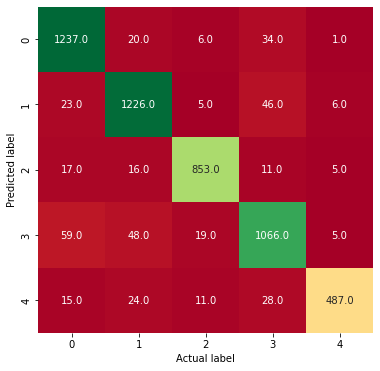

In [74]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [75]:
Topicnames_target = ["Bank account services", 
                     "Credit card / Prepaid card", 
                     "Mortgages/loans", 
                     "Theft/Dispute reporting", 
                     "Others"]

In [76]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.92      0.95      0.93      1298
Credit card / Prepaid card       0.92      0.94      0.93      1306
           Mortgages/loans       0.95      0.95      0.95       902
   Theft/Dispute reporting       0.90      0.89      0.90      1197
                    Others       0.97      0.86      0.91       565

                  accuracy                           0.92      5268
                 macro avg       0.93      0.92      0.92      5268
              weighted avg       0.92      0.92      0.92      5268



#### The overall accuracy of the Logistic Regression model is 92%.
#### Precision and Recall are 93% and 92% respectively which makes this is a very good model.

## Decision Tree

In [77]:
# Importing DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [78]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic_num'], test_size=0.25, random_state=42)

In [79]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [80]:
# Getting the score of the base model
dt.score(X_test, y_test)

0.7853075170842825

##### With base Decision Tree model, we get an accuracy of 78.53%

#### HyperParameter Tuning

In [81]:
dt_grid = {"max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [82]:
# Setup grid hyperparameter search for LogisticRegression
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


In [83]:
# Check best parameters
dt_hpt.best_params_

{'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 2}

In [84]:
# Evaluating the tuned model
dt_hpt.score(X_test, y_test)

0.7763857251328777

#### With the tuned Decision Tree model, we get an accuracy of 77.63% which is less than the base model's accuracy of 78.53%

In [85]:
# Save Logistic Regression Model
pickle.dump(dt_hpt, open("dt_model.pk1", "wb"))

#### Model Evaluation

In [86]:
# Load pickled model
dt_model = pickle.load(open("dt_model.pk1", "rb"))

In [87]:
# Make predictions on test data
y_pred = dt_model.predict(X_test)

In [88]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1036   70   28  145   19]
 [  33 1083   15  162   13]
 [  40   21  697  120   24]
 [ 146  114   16  901   20]
 [  54   52   26   60  373]]


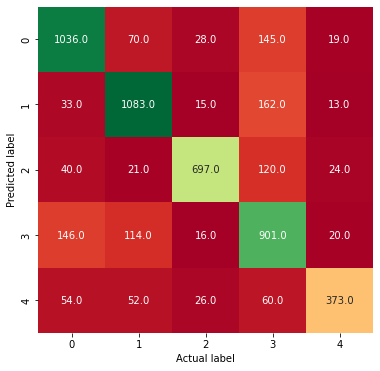

In [89]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [90]:
Topicnames_target = ["Bank account services", 
                     "Credit card / Prepaid card", 
                     "Mortgages/loans", 
                     "Theft/Dispute reporting",
                     "Others"]

In [91]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.79      0.80      0.79      1298
Credit card / Prepaid card       0.81      0.83      0.82      1306
           Mortgages/loans       0.89      0.77      0.83       902
   Theft/Dispute reporting       0.65      0.75      0.70      1197
                    Others       0.83      0.66      0.74       565

                  accuracy                           0.78      5268
                 macro avg       0.79      0.76      0.77      5268
              weighted avg       0.78      0.78      0.78      5268



#### The overall accuracy of the Decision Tree model is 78%
#### Precision and Recall are 79% and 76% respectively
#### This is an okay model but much poor compared to Logistic Regression where the accuracy was 92%

## Conclusion

### Based on the above results, Logistic Regression is the better model with an accuracy of 92% comapred to Decision Tree model which is just 78% accurate. 
### Precision and Recall of LR model is also better at 93% and 92% as compared to DT model that stands at 79% and 76% respectively. 